# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import keras
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/lenta_40k.csv')

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [9]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [10]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [11]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [13]:
# GRU 1 layer

inputs = tf.keras.layers.Input(shape=MAX_LEN)
Embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30) (inputs)

GRU = tf.keras.layers.GRU(128, return_sequences=False) (Embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (GRU)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [14]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=5)

Epoch 1/5
43/43 [==============================] - 17s 261ms/step - loss: 2.5571 - f1: 0.0029 - rec@prec: 0.0000e+00 - val_loss: 2.3232 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 [==============================] - 8s 188ms/step - loss: 2.2722 - f1: 0.0000e+00 - rec@prec: 3.5597e-04 - val_loss: 2.2022 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/5
43/43 [==============================] - 6s 148ms/step - loss: 2.0805 - f1: 0.0044 - rec@prec: 0.0015 - val_loss: 1.9747 - val_f1: 0.0248 - val_rec@prec: 0.0203
Epoch 4/5
43/43 [==============================] - 8s 179ms/step - loss: 1.8839 - f1: 0.0719 - rec@prec: 0.0358 - val_loss: 1.8935 - val_f1: 0.1281 - val_rec@prec: 0.0500
Epoch 5/5
43/43 [==============================] - 5s 116ms/step - loss: 1.6648 - f1: 0.2484 - rec@prec: 0.1313 - val_loss: 1.7187 - val_f1: 0.2148 - val_rec@prec: 0.0933


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


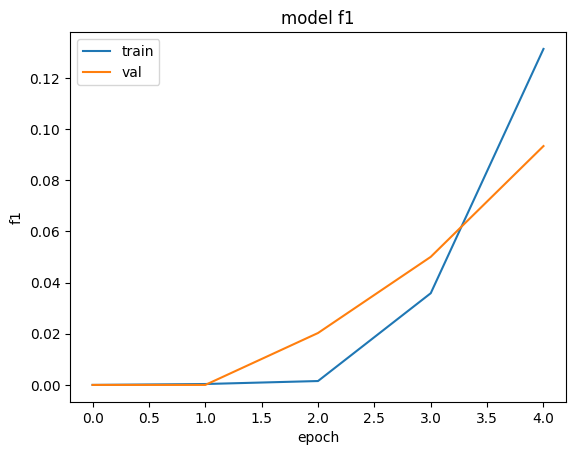

In [15]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# LSTM 1 layer

inputs = tf.keras.layers.Input(shape=MAX_LEN)
Embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30) (inputs)

LSTM = tf.keras.layers.LSTM(128, return_sequences=False) (Embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (LSTM)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [17]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=5)

Epoch 1/5
43/43 [==============================] - 19s 348ms/step - loss: 2.4559 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3200 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 [==============================] - 6s 148ms/step - loss: 2.3138 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3006 - val_f1: 0.0000e+00 - val_rec@prec: 0.0032
Epoch 3/5
43/43 [==============================] - 5s 127ms/step - loss: 2.2598 - f1: 0.0000e+00 - rec@prec: 2.3732e-05 - val_loss: 2.1755 - val_f1: 0.0000e+00 - val_rec@prec: 0.0054
Epoch 4/5
43/43 [==============================] - 5s 119ms/step - loss: 1.9291 - f1: 0.0615 - rec@prec: 0.0566 - val_loss: 1.7184 - val_f1: 0.1530 - val_rec@prec: 0.1204
Epoch 5/5
43/43 [==============================] - 5s 127ms/step - loss: 1.6454 - f1: 0.2488 - rec@prec: 0.1565 - val_loss: 1.6076 - val_f1: 0.3518 - val_rec@prec: 0.1885


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


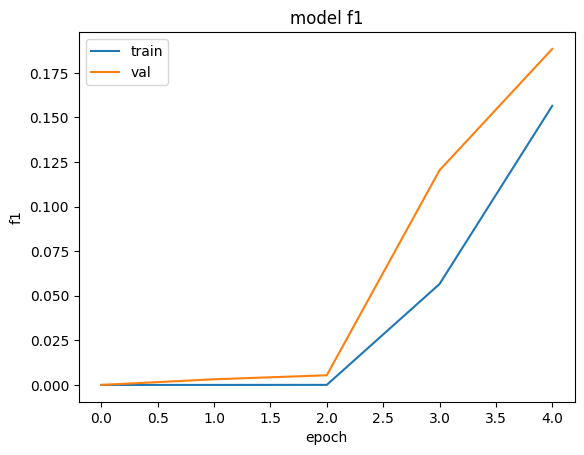

In [18]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
# LSTM and GRU

inputs = tf.keras.layers.Input(shape=MAX_LEN)
Embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30) (inputs)

LSTM = tf.keras.layers.LSTM(128, return_sequences=True) (Embeddings)
GRU = tf.keras.layers.GRU(128) (LSTM)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (GRU)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [20]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=5)

Epoch 1/5
43/43 [==============================] - 12s 199ms/step - loss: 2.4556 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3104 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 [==============================] - 6s 142ms/step - loss: 2.2211 - f1: 3.3223e-04 - rec@prec: 0.0000e+00 - val_loss: 2.0743 - val_f1: 0.0000e+00 - val_rec@prec: 0.0018
Epoch 3/5
43/43 [==============================] - 6s 149ms/step - loss: 1.8618 - f1: 0.0373 - rec@prec: 0.0026 - val_loss: 1.6783 - val_f1: 0.2177 - val_rec@prec: 0.0951
Epoch 4/5
43/43 [==============================] - 6s 144ms/step - loss: 1.4174 - f1: 0.4248 - rec@prec: 0.1921 - val_loss: 1.3567 - val_f1: 0.5587 - val_rec@prec: 0.2426
Epoch 5/5
43/43 [==============================] - 7s 156ms/step - loss: 1.0795 - f1: 0.6534 - rec@prec: 0.5484 - val_loss: 1.2093 - val_f1: 0.6406 - val_rec@prec: 0.4932


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


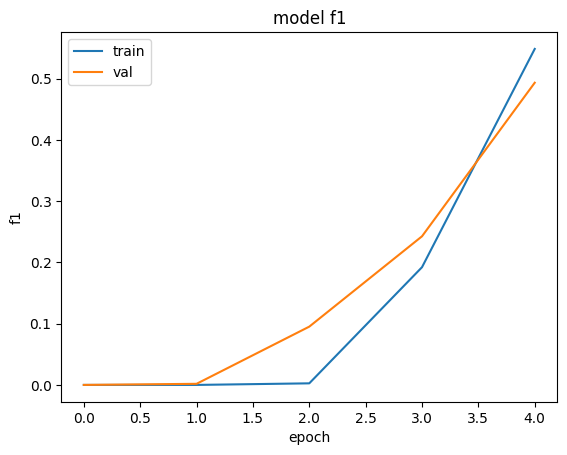

In [21]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# 1 BIGRU and 2 LSTM

inputs = tf.keras.layers.Input(shape=MAX_LEN)
Embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30) (inputs)

LSTM1 = tf.keras.layers.LSTM(128, return_sequences=True) (Embeddings)
LSTM2 = tf.keras.layers.LSTM(128, return_sequences=True) (LSTM1)

BIGRU = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)) (LSTM2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (BIGRU)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [23]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=5)

Epoch 1/5
43/43 [==============================] - 20s 315ms/step - loss: 2.4422 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3043 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 [==============================] - 14s 333ms/step - loss: 2.0684 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 1.8692 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/5
43/43 [==============================] - 16s 377ms/step - loss: 1.7591 - f1: 0.0136 - rec@prec: 0.0011 - val_loss: 1.7277 - val_f1: 0.0473 - val_rec@prec: 0.0455
Epoch 4/5
43/43 [==============================] - 13s 300ms/step - loss: 1.5358 - f1: 0.2167 - rec@prec: 0.0948 - val_loss: 1.5789 - val_f1: 0.2336 - val_rec@prec: 0.1285
Epoch 5/5
43/43 [==============================] - 11s 255ms/step - loss: 1.2879 - f1: 0.4392 - rec@prec: 0.2428 - val_loss: 1.3400 - val_f1: 0.5344 - val_rec@prec: 0.3282


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


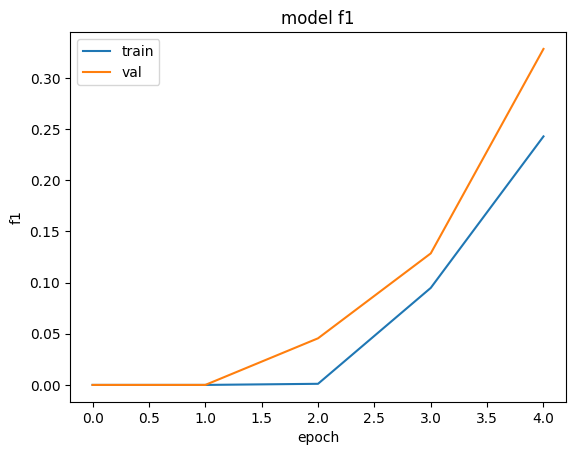

In [24]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# 3 LSTM and 5 GRU

inputs = tf.keras.layers.Input(shape=MAX_LEN)
Embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30) (inputs)

LSTM1 = tf.keras.layers.LSTM(128, return_sequences=True) (Embeddings)
GRU1 = tf.keras.layers.GRU(128, return_sequences=True) (LSTM1)
LSTM2 = tf.keras.layers.LSTM(128, return_sequences=True) (GRU1)
GRU2 = tf.keras.layers.GRU(128, return_sequences=True) (LSTM2)
LSTM3 = tf.keras.layers.LSTM(128, return_sequences=True) (GRU2)
GRU3 = tf.keras.layers.GRU(128, return_sequences=True) (LSTM3)
GRU4 = tf.keras.layers.GRU(128, return_sequences=True) (GRU3)
GRU5 = tf.keras.layers.GRU(128) (GRU4)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (GRU5)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [26]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=5)

Epoch 1/5
43/43 [==============================] - 37s 572ms/step - loss: 2.4101 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3204 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 [==============================] - 23s 534ms/step - loss: 2.1868 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 1.9614 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/5
43/43 [==============================] - 22s 510ms/step - loss: 1.7853 - f1: 0.0734 - rec@prec: 0.0394 - val_loss: 1.7340 - val_f1: 0.2403 - val_rec@prec: 0.1046
Epoch 4/5
43/43 [==============================] - 21s 498ms/step - loss: 1.5595 - f1: 0.2416 - rec@prec: 0.1221 - val_loss: 1.6638 - val_f1: 0.2552 - val_rec@prec: 0.1280
Epoch 5/5
43/43 [==============================] - 22s 508ms/step - loss: 1.4465 - f1: 0.3862 - rec@prec: 0.1734 - val_loss: 1.6402 - val_f1: 0.3383 - val_rec@prec: 0.1551


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


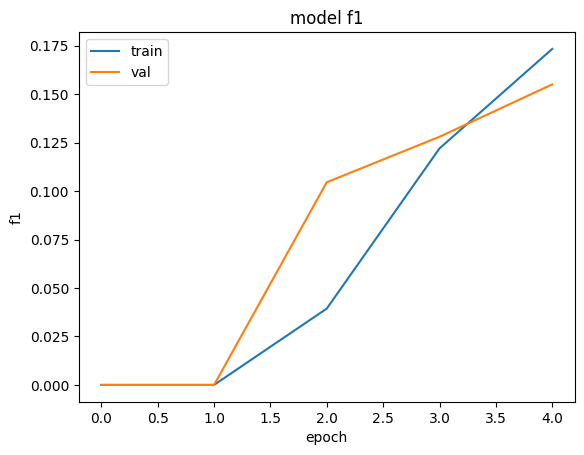

In [27]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
# 1 BIGRU and 1 BILSTM bit different model for forward or backward

inputs = tf.keras.layers.Input(shape=MAX_LEN)
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30) (inputs)

BIGRU = keras.layers.Bidirectional(
                                       keras.layers.GRU(128, return_sequences=True),
                        backward_layer=keras.layers.GRU(128, return_sequences=True,
                                                            go_backwards=True))(embeddings)
BISTLM = keras.layers.Bidirectional(
                                       keras.layers.LSTM(128),
                        backward_layer=keras.layers.LSTM(128,
                                                            go_backwards=True))(BIGRU)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (BISTLM)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [29]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=5)

Epoch 1/5
43/43 [==============================] - 22s 357ms/step - loss: 2.4296 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2994 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 [==============================] - 14s 319ms/step - loss: 2.0650 - f1: 0.0161 - rec@prec: 0.0014 - val_loss: 1.7168 - val_f1: 0.1638 - val_rec@prec: 0.0541
Epoch 3/5
43/43 [==============================] - 13s 313ms/step - loss: 1.5047 - f1: 0.3841 - rec@prec: 0.1407 - val_loss: 1.5028 - val_f1: 0.4916 - val_rec@prec: 0.2124
Epoch 4/5
43/43 [==============================] - 13s 305ms/step - loss: 1.3110 - f1: 0.5211 - rec@prec: 0.3004 - val_loss: 1.3221 - val_f1: 0.5679 - val_rec@prec: 0.3521
Epoch 5/5
43/43 [==============================] - 13s 297ms/step - loss: 1.1441 - f1: 0.6199 - rec@prec: 0.4673 - val_loss: 1.3903 - val_f1: 0.5587 - val_rec@prec: 0.3305


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


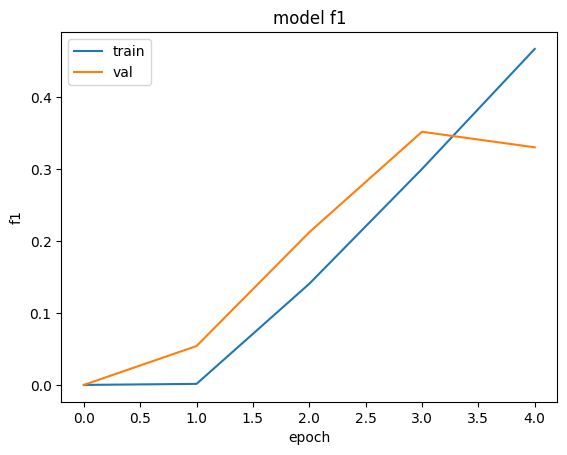

In [30]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
# LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

inputs = tf.keras.layers.Input(shape=MAX_LEN)
Embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30) (inputs)

LSTM1 = tf.keras.layers.LSTM(128, return_sequences=True) (Embeddings)
GRU1 = tf.keras.layers.GRU(128, return_sequences=True) (LSTM1)

BISTLM = keras.layers.Bidirectional(
                                       keras.layers.LSTM(128, return_sequences=True),
                        backward_layer=keras.layers.LSTM(128, return_sequences=True,
                                                            go_backwards=True))(GRU1)
BIGRU = keras.layers.Bidirectional(
                                       keras.layers.GRU(128, return_sequences=True),
                        backward_layer=keras.layers.GRU(128, return_sequences=True,
                                                            go_backwards=True))(BISTLM)

GRU2 = tf.keras.layers.GRU(128, return_sequences=True,) (BIGRU)
LSTM2 = tf.keras.layers.LSTM(128) (GRU2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (LSTM2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])



In [43]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=5)

Epoch 1/5
43/43 [==============================] - 42s 666ms/step - loss: 2.3998 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3225 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 [==============================] - 25s 585ms/step - loss: 2.3219 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2949 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/5
43/43 [==============================] - 25s 579ms/step - loss: 2.0759 - f1: 0.0084 - rec@prec: 2.8478e-04 - val_loss: 1.8024 - val_f1: 0.1141 - val_rec@prec: 0.0361
Epoch 4/5
43/43 [==============================] - 25s 586ms/step - loss: 1.6422 - f1: 0.2118 - rec@prec: 0.0668 - val_loss: 1.6633 - val_f1: 0.2995 - val_rec@prec: 0.0577
Epoch 5/5
43/43 [==============================] - 25s 580ms/step - loss: 1.4621 - f1: 0.4150 - rec@prec: 0.1295 - val_loss: 1.5779 - val_f1: 0.3551 - val_rec@prec: 0.1159


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


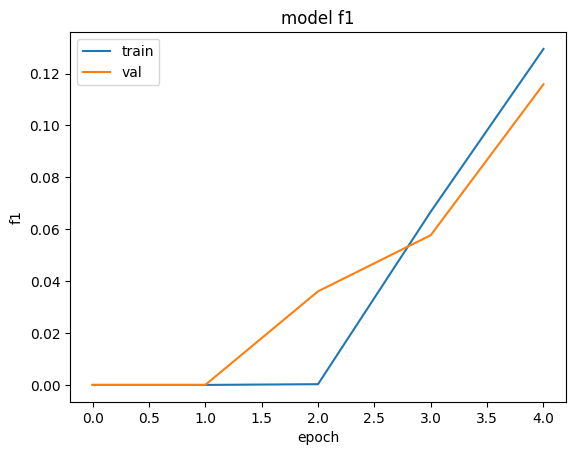

In [44]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [4]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset
import gensim.downloader

dataset = load_dataset("tner/wikiann", 'ru')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
glove_vectors = gensim.downloader.load('word2vec-ruscorpora-300')

[============================----------------------] 57.1% 113.4/198.8MB downloaded

In [12]:
inputs = tf.keras.layers.Input(shape=MAX_LEN)
embeddings = tf.keras.layers.Embedding(input_dim=glove_vectors.vectors.shape[0], output_dim=300, weights=[glove_vectors.vectors], input_length=MAX_LEN, trainable=False) (inputs)

BISTLM1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
BISTLM2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(BISTLM1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (BISTLM2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 54, 300)           55491900  
                                                                 
 bidirectional_2 (Bidirecti  (None, 54, 256)           439296    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 54, 256)           394240    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 54, 8)             2056      
                                                                 
Total params: 56327492 (214.87 MB)
Trainable params: 835592

In [14]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=10)

Epoch 1/10
157/157 [==============================] - 12s 40ms/step - loss: 0.2202 - accuracy: 0.9347 - val_loss: 0.1443 - val_accuracy: 0.9555
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.1284 - accuracy: 0.9591 - val_loss: 0.1172 - val_accuracy: 0.9634
Epoch 3/10
157/157 [==============================] - 5s 29ms/step - loss: 0.1015 - accuracy: 0.9669 - val_loss: 0.0916 - val_accuracy: 0.9702
Epoch 4/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0885 - accuracy: 0.9707 - val_loss: 0.0844 - val_accuracy: 0.9723
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0806 - accuracy: 0.9733 - val_loss: 0.0837 - val_accuracy: 0.9730
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0760 - accuracy: 0.9749 - val_loss: 0.0864 - val_accuracy: 0.9725
Epoch 7/10
157/157 [==============================] - 5s 30ms/step - loss: 0.0725 - accuracy: 0.9761 - val_loss: 0.0818 - val_accuracy: 0.973

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


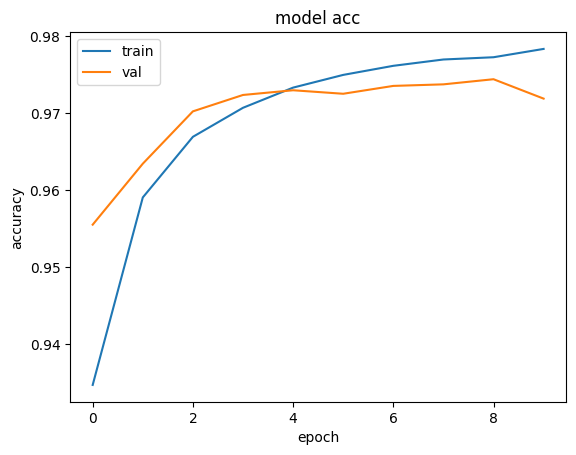

In [15]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import classification_report


pred = model.predict(X_test).argmax(2)

print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 [==============================] - 4s 6ms/step
              precision    recall  f1-score   support

           O       0.45      0.67      0.53      4560
       B-PER       0.79      0.29      0.43      4074
       I-PER       0.93      0.72      0.81      3542
       B-ORG       0.40      0.68      0.50      3060
       I-ORG       0.79      0.52      0.63      8008
       B-LOC       0.94      0.83      0.88      7544
       I-LOC       0.86      0.91      0.88     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.77      0.70      0.71    540000
weighted avg       0.98      0.97      0.97    540000



In [17]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [18]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)


1/1 [==============================] - 0s 52ms/step


[('Алексей', 'I-LOC'),
 ('сказал', 'I-LOC'),
 ('Светлане', 'I-LOC'),
 (',', 'I-LOC'),
 ('чтобы', 'I-LOC'),
 ('она', 'I-LOC'),
 ('собиралась', 'I-LOC'),
 ('на', 'I-LOC'),
 ('поезд', 'I-LOC'),
 ('в', 'I-LOC'),
 ('Москву', 'O'),
 ('.', 'I-LOC')]

In [19]:
label_seq('Алексей? привет', word2id, id2labels, MAX_LEN, model)


1/1 [==============================] - 0s 22ms/step


[('Алексей', 'B-PER'), ('?', 'I-ORG'), ('привет', 'I-ORG')]

In [20]:
inputs = tf.keras.layers.Input(shape=MAX_LEN)
embeddings = tf.keras.layers.Embedding(input_dim=glove_vectors.vectors.shape[0], output_dim=300, weights=[glove_vectors.vectors], input_length=MAX_LEN, trainable=False) (inputs)

BIGRU1 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(embeddings)
BIGRU2 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(BIGRU1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (BIGRU2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [21]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=10)

Epoch 1/10
157/157 [==============================] - 15s 34ms/step - loss: 0.2077 - accuracy: 0.9422 - val_loss: 0.1256 - val_accuracy: 0.9594
Epoch 2/10
157/157 [==============================] - 4s 24ms/step - loss: 0.1055 - accuracy: 0.9648 - val_loss: 0.0972 - val_accuracy: 0.9686
Epoch 3/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0870 - accuracy: 0.9709 - val_loss: 0.0888 - val_accuracy: 0.9712
Epoch 4/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0791 - accuracy: 0.9737 - val_loss: 0.0911 - val_accuracy: 0.9710
Epoch 5/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0744 - accuracy: 0.9754 - val_loss: 0.0851 - val_accuracy: 0.9729
Epoch 6/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0702 - accuracy: 0.9767 - val_loss: 0.0902 - val_accuracy: 0.9711
Epoch 7/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0676 - accuracy: 0.9776 - val_loss: 0.0896 - val_accuracy: 0.971

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


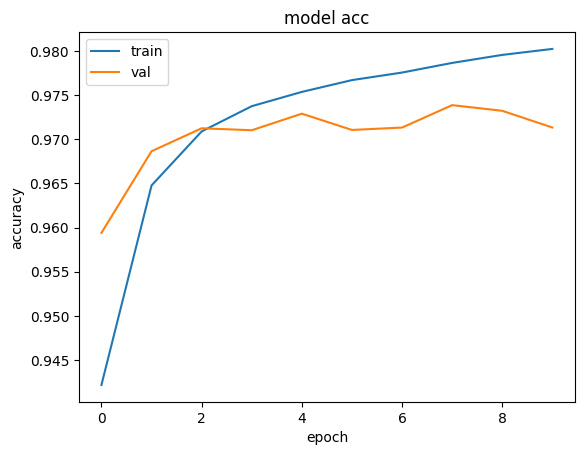

In [22]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
pred = model.predict(X_test).argmax(2)

print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 [==============================] - 6s 10ms/step
              precision    recall  f1-score   support

           O       0.44      0.69      0.54      4560
       B-PER       0.78      0.33      0.46      4074
       I-PER       0.94      0.72      0.82      3542
       B-ORG       0.33      0.76      0.46      3060
       I-ORG       0.77      0.57      0.66      8008
       B-LOC       0.94      0.83      0.88      7544
       I-LOC       0.89      0.88      0.89     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.76      0.72      0.71    540000
weighted avg       0.98      0.97      0.97    540000



In [24]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)


1/1 [==============================] - 0s 22ms/step


[('Алексей', 'I-LOC'),
 ('сказал', 'I-LOC'),
 ('Светлане', 'I-LOC'),
 (',', 'I-LOC'),
 ('чтобы', 'O'),
 ('она', 'I-LOC'),
 ('собиралась', 'I-LOC'),
 ('на', 'I-LOC'),
 ('поезд', 'I-LOC'),
 ('в', 'I-LOC'),
 ('Москву', 'O'),
 ('.', 'I-LOC')]

In [25]:
label_seq('Алексей? привет', word2id, id2labels, MAX_LEN, model)


1/1 [==============================] - 0s 33ms/step


[('Алексей', 'B-PER'), ('?', 'I-ORG'), ('привет', 'I-ORG')]